Discente: Helvecio Bezerra Leal Neto

Doscente: Dr. Marcos Quiles

### Projeto 1 - Multilayer Perceptron (MLP)

Utilizar a rede MLP para:
- Realizar testes com 3(ou mais) datasets selecionados do repositório da UCI (iris,
etc...) para várias configuração da rede
- Ilustrar graficamente o processo de aprendizagem pela redução do erro quadrático
médio
- Dividir o conjunto em duas partes (Treino e Validação)
- Entregar um relatório descrevendo os experimentos


Considerar:
- Impacto do termo de momentum
- Impacto da regularização L2

### Bibliotecas

In [1]:
from __future__ import print_function
import os
import sys
import pandas as pd
import numpy as np
%matplotlib inline
from matplotlib import pyplot as plt
import seaborn as sns
import datetime

In [2]:
df = pd.read_csv('dataset/PRSA_data.csv')

In [24]:
print('Tamanho do dataset: ',df.shape[0], ', quantiade de atributos: ', df.shape[1])
df.head()

Tamanho do dataset:  43824 , quantiade de atributos:  15


,No,year,month,day,hour,pm2.5,DEWP,TEMP,PRES,cbwd,Iws,Is,Ir,datetime,scaled_PRES
0,1,2010,1,1,0,NaN,-21,-11.0,1021.0,NW,1.79,0,0,2010-01-01 00:00:00,0.545455
1,2,2010,1,1,1,NaN,-21,-12.0,1020.0,NW,4.92,0,0,2010-01-01 01:00:00,0.527273
2,3,2010,1,1,2,NaN,-21,-11.0,1019.0,NW,6.71,0,0,2010-01-01 02:00:00,0.509091
3,4,2010,1,1,3,NaN,-21,-14.0,1019.0,NW,9.84,0,0,2010-01-01 03:00:00,0.509091
4,5,2010,1,1,4,NaN,-20,-12.0,1018.0,NW,12.97,0,0,2010-01-01 04:00:00,0.490909


In [25]:
df['datetime'] = df[['year','month','day','hour']].apply(lambda row:
            datetime.datetime(year=row['year'], month=row['month'], day=row['day'], hour=row['hour']),axis=1)
df.sort_values('datetime', ascending=True,inplace=True)

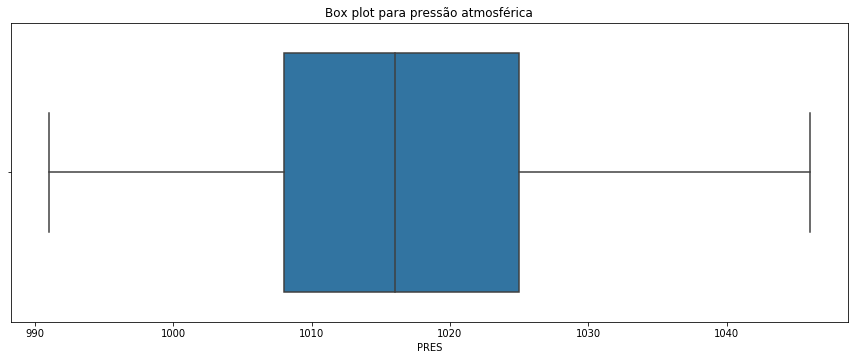

In [26]:
plt.figure(figsize=(15, 5.5))
g = sns.boxplot(df['PRES'])
g.set_title('Box plot para pressão atmosférica')
plt.show()

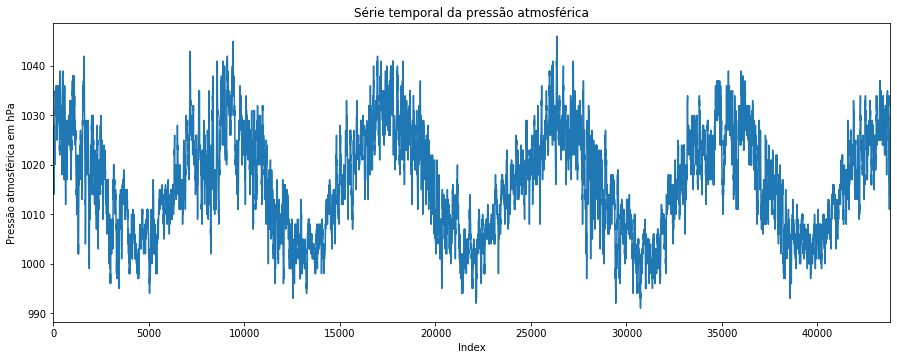

In [29]:
plt.figure(figsize=(15,5.5))
g = sns.tsplot(df['PRES'])
g.set_title('Série temporal da pressão atmosférica')
g.set_xlabel('Index')
g.set_ylabel('Pressão atmosférica em hPa')
plt.show()

In [30]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0,1))
df['scaled_PRES'] = scaler.fit_transform(np.array(df['PRES']).reshape(-1,1))

In [31]:
df.head()

,No,year,month,day,hour,pm2.5,DEWP,TEMP,PRES,cbwd,Iws,Is,Ir,datetime,scaled_PRES
0,1,2010,1,1,0,NaN,-21,-11.0,1021.0,NW,1.79,0,0,2010-01-01 00:00:00,0.545455
1,2,2010,1,1,1,NaN,-21,-12.0,1020.0,NW,4.92,0,0,2010-01-01 01:00:00,0.527273
2,3,2010,1,1,2,NaN,-21,-11.0,1019.0,NW,6.71,0,0,2010-01-01 02:00:00,0.509091
3,4,2010,1,1,3,NaN,-21,-14.0,1019.0,NW,9.84,0,0,2010-01-01 03:00:00,0.509091
4,5,2010,1,1,4,NaN,-20,-12.0,1018.0,NW,12.97,0,0,2010-01-01 04:00:00,0.490909


- Split into two parts:
   * Train set - trained neural networks
   * Validation set
   
- Used validation set:
  * Evaluate model
  * Determine number of epochs

In [34]:
## Split Train datetime Year=2014, Month=01 Day = 01 Hour=01
split_date = datetime.datetime(year= 2014, month=1,day=1,hour=0)
df_train = df.loc[df['datetime']<split_date]

df_val = df.loc[df['datetime']>=split_date]

print('Tamanho do dataset para treinamento: ',df_train.shape[0])
print('Tamanho do dataset para validação: ',df_val.shape[0])
df_val.reset_index(drop=True, inplace=True)

Tamanho do dataset para treinamento:  35064
Tamanho do dataset para validação:  8760


/ssd/miniconda3/envs/cap351/lib/python3.7/site-packages/seaborn/timeseries.py:183: UserWarning: The `tsplot` function is deprecated and will be removed in a future release. Please update your code to use the new `lineplot` function.
  warnings.warn(msg, UserWarning)


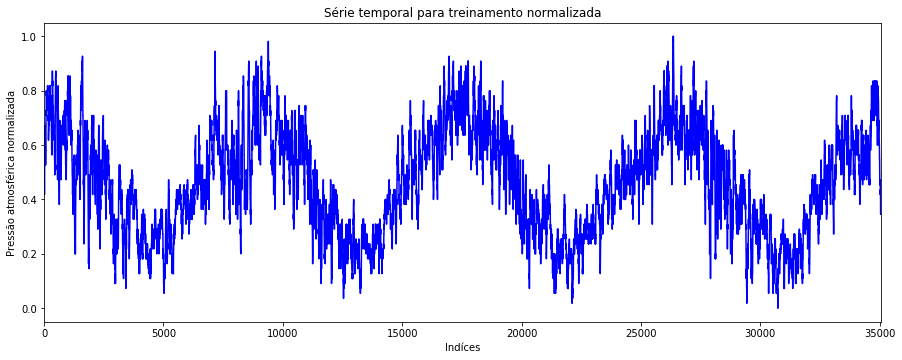

In [35]:
plt.figure(figsize=(15, 5.5))
g = sns.tsplot(df_train['scaled_PRES'], color='b')
g.set_title('Série temporal para treinamento normalizada')
g.set_xlabel('Indíces')
g.set_ylabel('Pressão atmosférica normalizada')
plt.show()

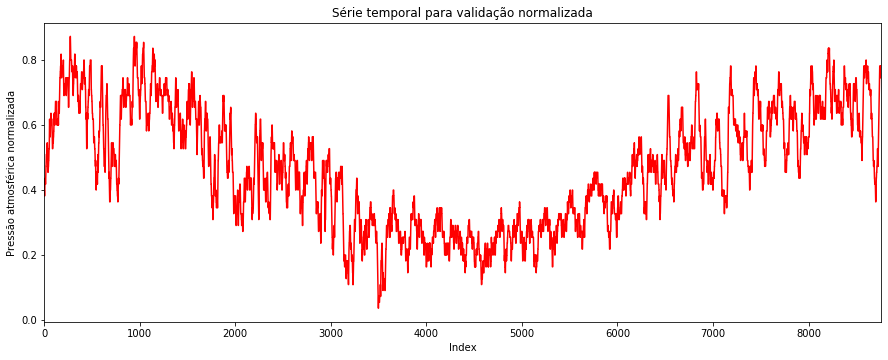

In [36]:
plt.figure(figsize=(15, 5.5))
g = sns.tsplot(df_val['scaled_PRES'], color='r')
g.set_title('Série temporal para validação normalizada')
g.set_xlabel('Index')
g.set_ylabel('Pressão atmosférica normalizada')
plt.show()

Now we need to generate regresses X and target variable Y for train and validation, a 2d array of regressors and one the array of target is created from the original 1d array of the scaled underscore press column in the data frames;

Function that takes the original time series and the number of time steps as input to return the array of X from Y 

In [37]:
def makeYx(ts, nb_timesteps):
    
    X = []
    y = []
    
    for i in range(nb_timesteps, ts.shape[0]):
        X.append(list(ts.loc[i-nb_timesteps:i-1]))
        y.append(ts.loc[i])
        
    X,y = np.array(X), np.array(y)
    return X,y

In [38]:
X_train, y_train = makeYx(df_train['scaled_PRES'], 7)
print('Tamanho do vetor para treinamento: ', X_train.shape, y_train.shape)

Tramanho do vetor para treinamento:  (35057, 7) (35057,)


In [39]:
X_val, y_val = makeYx(df_val['scaled_PRES'], 7)
print('Tamanho do vetor para validação: ', X_val.shape, y_val.shape)

Tamanho do vetor para validação:  (8753, 7) (8753,)


In [41]:
from keras.layers import Dense, Input, Dropout
from keras.optimizers import SGD
from keras.models import Model
from keras.models import load_model
from keras.callbacks import ModelCheckpoint

In [43]:
# Número de instancias para rodar na primeira camada
input_layer = Input(shape=(7,),dtype='float32')

In [45]:
# camadas densas e função de ativação
dense1 = Dense(32, activation = 'linear')(input_layer)
dense2 = Dense(16, activation = 'linear')(dense1)
dense3 = Dense(16, activation = 'linear')(dense2)

In [47]:
# dropout foi usado para regularizar a rede
# dropout é adicionada antes da camada de saída
# Dropout ajusta aleatoriamente a fração dos neuronis de entrada como zero antes de passar para a próxima camada.
# a entrada aleatória atua essencialmente como agregação de bootstrap ou tipo de encapsulamento dos modelos
# random forests usam ensacamento construindo árvores em subconjuntos aleatórios a partir dos recursos de entrada

# 20% de aleatóriedade para os atributos de entrada
dropout_layer = Dropout(0.2)(dense3)

In [48]:
# o neurônio de saída da o valor de predição para o próximo dia de pressão atmosférica
output_layer = Dense(1, activation='linear')(dropout_layer)

In [49]:
# os valores da camada de entrada e camada de saída são encapsulados em um modelo de treinamento e validação

# O erro quadrado médio (MSE) é usado como função de perda
# a taxa de aprendizado dos pesos é atualizada nas médias móveis ponderadas exponencialmente
# a partir dos gradientes quadráticos dos pesos

# As funções summary exibe detalhes das camada, como o
# - forma de entrada e saída
# - número de pesos treináveis

ts_model = Model(inputs=input_layer, outputs=output_layer)
ts_model.compile(loss='mean_squared_error',optimizer='adam')
ts_model.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 7)                 0         
_________________________________________________________________
dense_4 (Dense)              (None, 32)                256       
_________________________________________________________________
dense_5 (Dense)              (None, 16)                528       
_________________________________________________________________
dense_6 (Dense)              (None, 16)                272       
_________________________________________________________________
dropout_2 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 17        
Total params: 1,073
Trainable params: 1,073
Non-trainable params: 0
_________________________________________________________________


O modelo é treinado chamando a função (fit) no objeto do modelo e passando os vetores X_ para treinar e Y_

In [50]:
# um objeto de ponto de verificação de modelo rastreia a função de perda no conjunto de dados de validação e salva a época
# em que a perda da função é mínima
save_weights_at = os.path.join('output','PRSA_data_2010.1.1-2014.12.31.{epoch:02d}-{val_loss:.4f}.hdf5')
save_best = ModelCheckpoint(save_weights_at, monitor='val_loss',verbose=0,
                            save_best_only=True, save_weights_only=False, mode='min',
                            period=1)

In [51]:
# Função FIT
ts_model.fit(x=X_train, y=y_train, batch_size=16, epochs=20,Marcos Fortunato
             verbose=1, callbacks=[save_best], validation_data=(X_val, y_val),
             shuffle=True)


Train on 35057 samples, validate on 8753 samples
Epoch 1/20
35057/35057 [==============================] - 6s 166us/step - loss: 0.0119 - val_loss: 0.0023
Epoch 2/20
35057/35057 [==============================] - 5s 144us/step - loss: 0.0016 - val_loss: 3.8765e-04
Epoch 3/20
35057/35057 [==============================] - 5s 153us/step - loss: 9.4988e-04 - val_loss: 2.3977e-04
Epoch 4/20
35057/35057 [==============================] - 5s 151us/step - loss: 8.7403e-04 - val_loss: 3.8828e-04
Epoch 5/20
35057/35057 [==============================] - 5s 151us/step - loss: 8.2273e-04 - val_loss: 1.7699e-04
Epoch 6/20
35057/35057 [==============================] - 5s 147us/step - loss: 7.9572e-04 - val_loss: 2.5097e-04
Epoch 7/20
35057/35057 [==============================] - 6s 157us/step - loss: 7.8331e-04 - val_loss: 5.8346e-04
Epoch 8/20
35057/35057 [==============================] - 5s 142us/step - loss: 7.7774e-04 - val_loss: 1.7542e-04
Epoch 9/20
35057/35057 [==========================

As previsões de pressão atmosférica são feitas a partir do melhor modelo salvo, os resultados de pressão atmosféricas normalizados são transformados inversamente para obter previsões sobre a pressão atmosférica original.

In [52]:
best_model = load_model(os.path.join('output', 'PRSA_data_2010.1.1-2014.12.31.04-0.0001.hdf5'))
preds = best_model.predict(X_val)
pred_PRES = scaler.inverse_transform(preds)
pred_PRES = np.squeeze(pred_PRES)

In [54]:
from sklearn.metrics import r2_score

In [55]:
r2 = r2_score(df_val['PRES'].loc[7:], pred_PRES)
print('Erro quadrático para o dataset de validação:', round(r2,4))

Erro quadrático para o dataset de validação: 0.9958


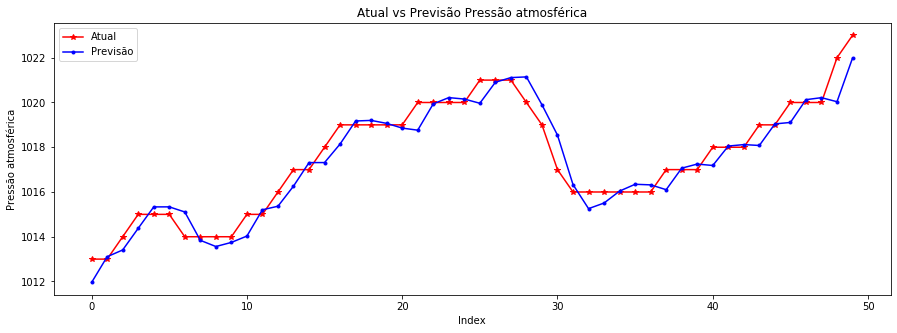

In [59]:
plt.figure(figsize=(15, 5))
plt.plot(range(50), df_val['PRES'].loc[7:56], linestyle='-', marker='*', color='r')
plt.plot(range(50), pred_PRES[:50], linestyle='-', marker='.', color='b')
plt.legend(['Atual','Previsão'], loc=2)
plt.title('Atual vs Previsão Pressão atmosférica')
plt.ylabel('Pressão atmosférica')
plt.xlabel('Index')
plt.show()

### Exemplo 02: Dataset INMET

Dataset 1: https://archive.ics.uci.edu/ml/datasets/Beijing+PM2.5+Data

In [113]:
df_mta = pd.read_csv('dataset/dados_monte_alegre.csv', delimiter=';')

In [114]:
print("Tamanho do dataset: ", df_mta.shape[0], ' quantidade de atributos: ', df_mta.shape[1])
df_mta.head()

Tamanho do dataset:  48777  quantidade de atributos:  11


,Estacao,Data,Hora,TempBulboSeco,TempBulboUmido,UmidadeRelativa,PressaoAtmEstacao,DirecaoVento,VelocidadeVento,Nebulosidade,Unnamed: 10
0,82181,01/04/1974,1200,24.5,22.8,87.0,996.3,5.0,3.0,0.8,NaN
1,82181,01/04/1974,1800,29.5,24.5,67.0,994.2,14.0,3.0,0.7,NaN
2,82181,02/04/1974,0,25.0,23.8,91.0,993.0,0.0,0.0,0.7,NaN
3,82181,02/04/1974,1200,24.9,23.2,87.0,994.6,32.0,1.0,0.8,NaN
4,82181,02/04/1974,1800,29.0,25.3,74.0,992.8,23.0,3.0,0.7,NaN


In [115]:
df_mta[['day','month','year']] = df_mta.Data.str.split('/', n = 3, expand = True)
df_mta['day'] = pd.to_numeric(df_mta.day)
df_mta['month'] = pd.to_numeric(df_mta.month)
df_mta['year'] = pd.to_numeric(df_mta.year)
df_mta = df_mta.replace([1200,1800],[12,18])

df_mta['datetime'] = df_mta[['day','month','year','Hora']].apply(lambda row:
                    datetime.datetime(year=row['year'], month=row['month'],day=row['day'],hour=row['Hora']),axis=1)
df_mta = df_mta.drop(columns=['Data','Hora','day','month','year','Unnamed: 10'])
df_mta = df_mta.set_index('datetime')
df_mta.sort_values('datetime',ascending=True,inplace=True)
df_mta.head()

,Estacao,TempBulboSeco,TempBulboUmido,UmidadeRelativa,PressaoAtmEstacao,DirecaoVento,VelocidadeVento,Nebulosidade
datetime,,,,,,,,
1974-04-01 12:00:00,82181,24.5,22.8,87.0,996.3,5.0,3.0,0.8
1974-04-01 18:00:00,82181,29.5,24.5,67.0,994.2,14.0,3.0,0.7
1974-04-02 00:00:00,82181,25.0,23.8,91.0,993.0,0.0,0.0,0.7
1974-04-02 12:00:00,82181,24.9,23.2,87.0,994.6,32.0,1.0,0.8
1974-04-02 18:00:00,82181,29.0,25.3,74.0,992.8,23.0,3.0,0.7


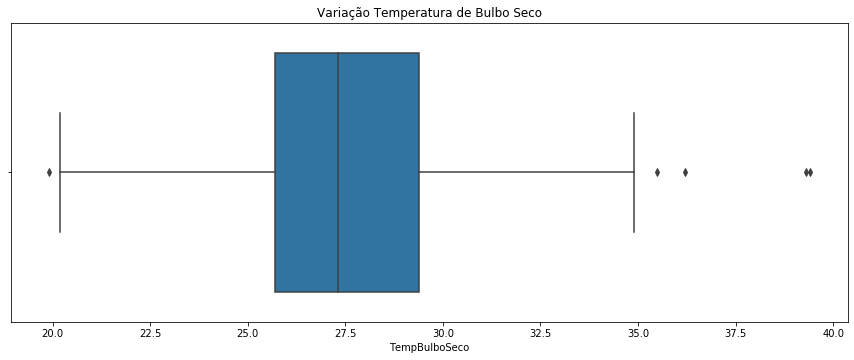

In [116]:
plt.figure(figsize=(15, 5.5))
g = sns.boxplot(df_mta['TempBulboSeco'])
g.set_title('Variação Temperatura de Bulbo Seco')
plt.show()

In [117]:
## Separar dados de treinamento
split_date = datetime.datetime(year=2014, month=1,day=1)

df_train_mta = df_mta.loc[df_mta.index<split_date]
df_val_mta = df_mta.loc[df_mta.index>=split_date]

print('Shape do treinamento: ', df_train_mta.shape)
print('Shape da validação: ', df_val_mta.shape)

Shape do treinamento:  (43323, 8)
Shape da validação:  (5454, 8)


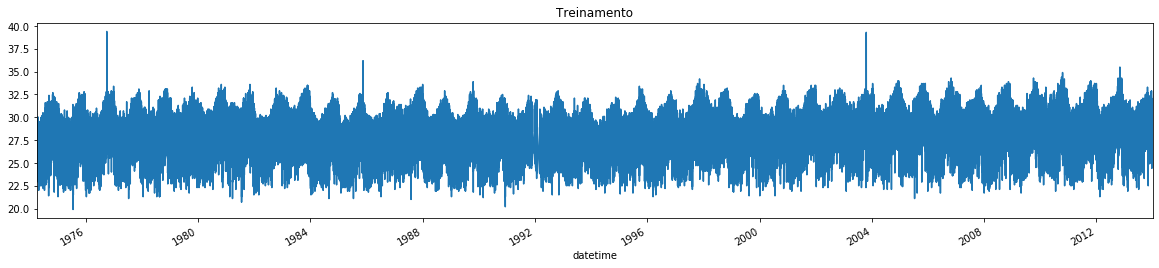

In [68]:
df_train_mta.TempBulboSeco.plot(figsize = (20,4), title='Treinamento')

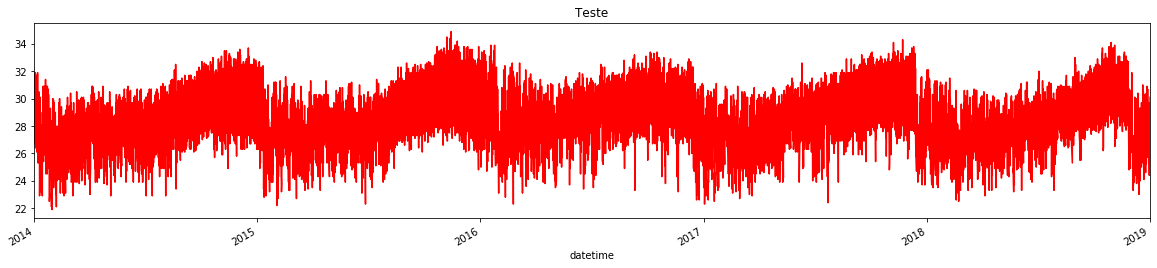

In [118]:
df_val_mta.TempBulboSeco.plot(figsize = (20,4), title='Teste', color='r')

### Normalização

In [119]:
scaler_mta = MinMaxScaler(feature_range=(0,1))
df_train_mta['Scaled_TempBulboSeco'] = scaler.fit_transform(np.array(df_train_mta['TempBulboSeco']).reshape(-1,1))
df_val_mta['Scaled_TempBulboSeco'] = scaler.fit_transform(np.array(df_val_mta['TempBulboSeco']).reshape(-1,1))

/ssd/miniconda3/envs/cap351/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/ssd/miniconda3/envs/cap351/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [120]:
df_train_mta.reset_index(inplace=True)
df_val_mta.reset_index(inplace=True)

In [122]:
X_train_mta, y_train_mta = makeYx(df_train_mta['Scaled_TempBulboSeco'], 3)
print('Tamanho dos vetores de treinamento: ', X_train_mta.shape, y_train_mta.shape)

X_val_mta, y_val_mta = makeYx(df_val_mta['Scaled_TempBulboSeco'], 3)
print('Tamanho dos vetores de validação: ', X_val_mta.shape, y_val_mta.shape)

X_train_mta = np.nan_to_num(X_train_mta)
y_train_mta = np.nan_to_num(y_train_mta)

Tamanho dos vetores de treinamento:  (43320, 3) (43320,)
Tamanho dos vetores de validação:  (5451, 3) (5451,)


In [128]:
input_layer = Input(shape=(3,),dtype='float32')

dense1 = Dense(32, activation = 'linear')(input_layer)
dense2 = Dense(16, activation = 'linear')(dense1)
dense3 = Dense(16, activation = 'linear')(dense2)

dropout_layer = Dropout(0.2)(dense3)
output_layer = Dense(1, activation='linear')(dropout_layer)

In [129]:
ts_model = Model(inputs=input_layer, outputs=output_layer)
ts_model.compile(loss='mean_squared_error',optimizer='adam')
ts_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_10 (InputLayer)        (None, 3)                 0         
_________________________________________________________________
dense_36 (Dense)             (None, 32)                128       
_________________________________________________________________
dense_37 (Dense)             (None, 16)                528       
_________________________________________________________________
dense_38 (Dense)             (None, 16)                272       
_________________________________________________________________
dropout_11 (Dropout)         (None, 16)                0         
_________________________________________________________________
dense_39 (Dense)             (None, 1)                 17        
Total params: 945
Trainable params: 945
Non-trainable params: 0
_________________________________________________________________


In [130]:
save_weights_at = os.path.join('output','mta_data.{epoch:02d}-{val_loss:.4f}.hdf5')
save_best = ModelCheckpoint(save_weights_at, monitor='val_loss',verbose=1,
                            save_best_only=True, save_weights_only=False, mode='min',
                            period=1)

In [131]:
# Fit function
ts_model.fit(x=X_train_mta, y=y_train_mta, batch_size=16, epochs=15,
             verbose=1, callbacks=[save_best], validation_data=(X_val_mta, y_val_mta),
             shuffle=True)

Train on 43320 samples, validate on 5451 samples
Epoch 1/16
43320/43320 [==============================] - 8s 192us/step - loss: 0.0072 - val_loss: 0.0125

Epoch 00001: val_loss improved from inf to 0.01249, saving model to output/mta_data.01-0.0125.hdf5
Epoch 2/16
43320/43320 [==============================] - 8s 187us/step - loss: 0.0057 - val_loss: 0.0118

Epoch 00002: val_loss improved from 0.01249 to 0.01178, saving model to output/mta_data.02-0.0118.hdf5
Epoch 3/16
43320/43320 [==============================] - 7s 158us/step - loss: 0.0056 - val_loss: 0.0118

Epoch 00003: val_loss did not improve from 0.01178
Epoch 4/16
43320/43320 [==============================] - 7s 168us/step - loss: 0.0056 - val_loss: 0.0122

Epoch 00004: val_loss did not improve from 0.01178
Epoch 5/16
43320/43320 [==============================] - 7s 164us/step - loss: 0.0056 - val_loss: 0.0117

Epoch 00005: val_loss improved from 0.01178 to 0.01173, saving model to output/mta_data.05-0.0117.hdf5
Epoch 6/1